# Covid-19 tracker - Cases, Mortality and Vaccinations

This small prototype project is to build a webscraper capable of gathering info on the current covid-19 pandemic, and map hotzones within countries. I'll potentially be making a nice GUI for this if it works well.

In [39]:
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import requests
import numpy as np
import pandas as pd

# Webscraping covid-19 data using beautifulsoup.
Below we're going to collect the data from the first source - https://www.worldometers.info/coronavirus/
We'll scrape a table of data from the website, and give the table an initial, rough, clean.

In [40]:
# worldwide data https://www.worldometers.info/coronavirus/
# uk tracker - inc. data https://coronavirus.data.gov.uk/details/vaccinations

url = "https://www.worldometers.info/coronavirus/"
htmlContent = requests.get(url).text

soup = BeautifulSoup(htmlContent, 'html.parser')
covidTable = soup.find("table",attrs={"id": "main_table_countries_today"})

In [41]:
# extract the table headings from the soup
head = covidTable.thead.find_all("tr")
headings = []

for th in head[0].find_all("th"):
    headings.append(th.text.replace("\n", "").strip())

In [42]:
# extract actual data from the soup
body = covidTable.tbody.find_all("tr")
data = []

# iterate through every row in the html
for r in range(1,len(body)):
    row = []
    # find all column entries in that particular row
    for tr in body[r].find_all("td"):
        row.append(tr.text.replace("\n","").strip())
    len(row)
    data.append(row)

## Now that we have all of the rows and column names, let's construct out pandas dataframe, and do some inital data cleaning to make our lives easier down the line.

In [43]:
df = pd.DataFrame(data,columns = headings)
df.head(20)

,#,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",...,TotalTests,Tests/1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,,Asia,"53,797,757","+129,500","752,499","+2,506","50,991,747","+179,708","2,053,511","27,133",...,,,,Asia,,,,,,
1,,South America,"30,846,353","+85,323","949,365","+2,435","27,966,022","+99,604","1,930,966","32,318",...,,,,South America,,,,,,
2,,Europe,"47,261,055","+38,067","1,088,066",+990,"44,678,307","+60,279","1,494,682","9,754",...,,,,Europe,,,,,,
3,,Africa,"5,123,576","+18,549","135,817",+428,"4,569,886","+10,361","417,873","2,856",...,,,,Africa,,,,,,
4,,Oceania,"70,529",+126,"1,256",+1,"67,505",+32,"1,768",10,...,,,,Australia/Oceania,,,,,,
5,,,721,,15,,706,,0,0,...,,,,,,,,,,
6,,World,"177,313,474","+286,428","3,835,580","+6,788","161,753,682","+386,835","11,724,212","83,811",...,,,,All,,,,,,
7,1,USA,"34,348,418","+9,047","615,638",+285,"28,574,794","+29,023","5,157,986","4,349",...,"495,949,125","1,490,009","332,849,650",North America,10,541,1,27,0.9,"15,496"
8,2,India,"29,632,261","+62,226","379,601","+1,470","28,380,634","+107,854","872,026","8,944",...,"381,375,984","273,800","1,392,901,572",Asia,47,"3,669",4,45,1,626
9,3,Brazil,"17,533,221","+78,360","490,696","+2,292","15,944,646","+90,382","1,097,879","8,318",...,"50,801,042","237,392","213,996,756",South America,12,436,4,366,11,"5,130"


In [44]:
# let's get rid of some annoying values contained within the dataframe
df = df.replace(',','', regex=True)
df = df.replace('\+','', regex=True)
df = df.replace('', 'NaN', regex=True)

#let's change the numbers present from string format to integer!
df = df.apply(pd.to_numeric, errors='ignore')

df.head(20)


,#,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",...,TotalTests,Tests/1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,NaN,Asia,53797757,129500,752499,2506,50991747,179708,2053511,27133,...,NaN,NaN,NaN,Asia,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,South America,30846353,85323,949365,2435,27966022,99604,1930966,32318,...,NaN,NaN,NaN,South America,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Europe,47261055,38067,1088066,990,44678307,60279,1494682,9754,...,NaN,NaN,NaN,Europe,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Africa,5123576,18549,135817,428,4569886,10361,417873,2856,...,NaN,NaN,NaN,Africa,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Oceania,70529,126,1256,1,67505,32,1768,10,...,NaN,NaN,NaN,Australia/Oceania,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,721,NaN,15,NaN,706,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,World,177313474,286428,3835580,6788,161753682,386835,11724212,83811,...,NaN,NaN,NaN,All,NaN,NaN,NaN,NaN,NaN,NaN
7,1,USA,34348418,9047,615638,285,28574794,29023,5157986,4349,...,495949125,1490009,332849650,North America,10,541,1,27,0.9,15496
8,2,India,29632261,62226,379601,1470,28380634,107854,872026,8944,...,381375984,273800,1392901572,Asia,47,3669,4,45,1,626
9,3,Brazil,17533221,78360,490696,2292,15944646,90382,1097879,8318,...,50801042,237392,213996756,South America,12,436,4,366,11,5130


# World covid-19 data
## First, let's look at extracting the data from the soup.
Below, we can extract the row from our soup that contains the cumulative world data for covid 19.

In [45]:
world_df = df.loc[df['Country,Other'] == "World"]

# record worldwide cases
worldwideCases = int(world_df.iloc[0]['TotalCases'])

# strip useless columns, clean data
world_df = world_df.drop(columns=['#','Tot\xa0Cases/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop', 'Population']).reset_index(drop=True)
world_df
 
# let's plot total cases, recovered, active (serious, non-serious), deaths in a pie chart

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Deaths/1M pop,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,World,177313474,286428,3835580,6788,161753682,386835,11724212,83811,492.1,All,NaN,NaN,NaN


## Next, we can visualise some interesting data we've gathered...
Let's construct some useful graphs to display this information. To do this, let's look at using matplotlib - an essential python module for plotting, analysing and displaying data.

In [46]:
# select our data for plotting:
world_df = world_df.filter(['TotalCases','TotalRecovered','Serious,Critical','ActiveCases','TotalDeaths'])

# This is the correct way to add a new column from existing columns!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
world_df = world_df.assign(NonCritical_Active = float(world_df['ActiveCases']) - float(world_df['Serious,Critical']))
world_df.rename(columns = {'NonCritical_Active':'Non-Critical, Active', 'Serious,Critical':'Critical, Active'}, inplace = True)

# let's add in percentage columns
world_df = world_df.assign(TotalRecoveredPerc = (int(world_df['TotalRecovered']) / int(world_df['TotalCases'])) * 100)
world_df = world_df.assign(CritPerc = (int(world_df['Critical, Active']) / int(world_df['TotalCases'])) * 100)
world_df = world_df.assign(DeathPerc = (int(world_df['TotalDeaths']) / int(world_df['TotalCases'])) * 100)
world_df = world_df.assign(NonCritPerc = (int(world_df['Non-Critical, Active']) / int(world_df['TotalCases'])) * 100)

# drop redundant
world_df = world_df.drop(columns = ['TotalCases','ActiveCases']).reset_index(drop=True)
world_df

,TotalRecovered,"Critical, Active",TotalDeaths,"Non-Critical, Active",TotalRecoveredPerc,CritPerc,DeathPerc,NonCritPerc
0,161753682,83811,3835580,11640401.0,91.224698,0.047267,2.163163,6.564871


TotalRecovered
Critical, Active
TotalDeaths
Non-Critical, Active


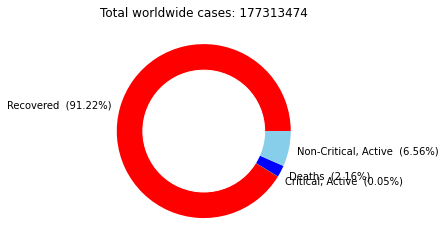

In [47]:

# grab the names and values of each piece of data
columns = world_df.columns
data = world_df.values.tolist()[0]

labels = []
x=0
for item in columns:
    if x < 4:
        print(item)
        labels.append(item.replace("Total","") + "  (" + str(round(world_df.iloc[0][x+4],2)) + "%)")
        x += 1


# plot the data in a donut pie chart
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(data[0:4], labels=labels, colors=['red','green','blue','skyblue'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Total worldwide cases: {}".format(worldwideCases))

# show the graph
plt.show()

## Here we extract continent data from the main dataframe, and place it in a new dataframe.

In [64]:
continents_df = df.iloc[0:5]

# strip useless columns, clean data
continents_df = continents_df.drop(columns=['#','Tot\xa0Cases/1M pop','Deaths/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop', 'Population', 'New Cases/1M pop', 'New Deaths/1M pop', 'Active Cases/1M pop', 'NewRecovered', 'NewDeaths', 'NewCases']).reset_index(drop=True)

continents_df.drop(columns=['Continent'], inplace=True)
continents_df


,"Country,Other",TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical"
0,Asia,53797757,752499,50991747,2053511,27133
1,South America,30846353,949365,27966022,1930966,32318
2,Europe,47261055,1088066,44678307,1494682,9754
3,Africa,5123576,135817,4569886,417873,2856
4,Oceania,70529,1256,67505,1768,10


## It looks like we're missing North American data - let's pull that data from the countries dataframe

In [65]:
na = df.loc[df['Continent'] == "North America"]
del na["Continent"]

na = na.drop(columns=['#','Tot\xa0Cases/1M pop','Deaths/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop', 'Population', 'New Cases/1M pop', 'New Deaths/1M pop', 'Active Cases/1M pop', 'NewRecovered', 'NewDeaths', 'NewCases']).reset_index(drop=True)
na = na.replace('','0', regex=True)


# create a row of data to append to the continents for North America


# continents_df = continents_df.assign(NonCritical_Active = float(world_df['ActiveCases']) - float(world_df['Serious,Critical']))

row = []
row.append("North America")

for column in na.columns[1:]:
    na[column] = pd.to_numeric(na[column], errors='coerce')
    row.append(round(na[column].sum()))
row = [row]

print(row)

continents_df = continents_df.append(pd.DataFrame( row, columns=continents_df.columns), ignore_index = True)
continents_df

[['North America', 40213483, 908562, 33479509, 5825412, 11740]]


,"Country,Other",TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical"
0,Asia,53797757,752499,50991747,2053511,27133
1,South America,30846353,949365,27966022,1930966,32318
2,Europe,47261055,1088066,44678307,1494682,9754
3,Africa,5123576,135817,4569886,417873,2856
4,Oceania,70529,1256,67505,1768,10
5,North America,40213483,908562,33479509,5825412,11740


C:\Users\marja\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Asia'),
  Text(1, 0, 'Europe'),
  Text(2, 0, 'North America'),
  Text(3, 0, 'South America'),
  Text(4, 0, 'Africa'),
  Text(5, 0, 'Oceania')])

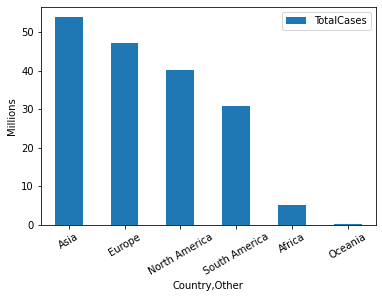

In [66]:
continent_totals_df = continents_df[['Country,Other', 'TotalCases']]
continent_totals_df.loc[:,'TotalCases'] = continent_totals_df.loc[:,'TotalCases']/1000000
continent_totals_df = continent_totals_df.sort_values(by=['TotalCases'],ascending=False)
continent_totals_df.plot(kind='bar', x="Country,Other", y="TotalCases")
plt.ylabel("Millions")
plt.xticks(rotation=30)

## Let's plot the statistics for each continent



In [73]:
continents_df = continents_df.filter(['TotalCases','Country,Other','TotalRecovered','Serious,Critical','ActiveCases','TotalDeaths'])
continents_df[['TotalCases', 'TotalRecovered','Serious,Critical','ActiveCases','TotalDeaths']] = continents_df[['TotalCases', 'TotalRecovered','Serious,Critical','ActiveCases','TotalDeaths']].apply(pd.to_numeric, errors = 'ignore')
# continents_df = continents_df.astype(dtype = int, errors = 'ignore')

nonCritical = continents_df.iloc[0]['ActiveCases'] - continents_df.iloc[0]['Serious,Critical']
continents_df.iloc[0]['ActiveCases'] = nonCritical
continents_df.rename(columns = {'ActiveCases':'Non-Critical, Active', 'Serious,Critical':'Critical, Active'}, inplace = True)

# let's add percentages
continents_df['Total Recovered Percentage'] = (continents_df['TotalRecovered'] / continents_df['TotalCases']) * 100
continents_df['Critical, Percentage'] = (continents_df['Critical, Active'] / continents_df['TotalCases']) * 100
continents_df['Non-Critical Percentage'] = (continents_df['Non-Critical, Active'] / continents_df['TotalCases']) * 100
continents_df['Death Percentage'] = (continents_df['TotalDeaths'] / continents_df['TotalCases']) * 100
continents_df


<ipython-input-73-c546714f0461>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continents_df.iloc[0]['ActiveCases'] = nonCritical


,TotalCases,"Country,Other",TotalRecovered,"Critical, Active","Non-Critical, Active",TotalDeaths,Total Recovered Percentage,"Critical, Percentage",Non-Critical Percentage,Death Percentage
0,53797757,Asia,50991747,27133,2053511,752499,94.784151,0.050435,3.817094,1.398755
1,30846353,South America,27966022,32318,1930966,949365,90.662329,0.104771,6.259949,3.077722
2,47261055,Europe,44678307,9754,1494682,1088066,94.535145,0.020639,3.162608,2.302247
3,5123576,Africa,4569886,2856,417873,135817,89.193290,0.055742,8.155886,2.650824
4,70529,Oceania,67505,10,1768,1256,95.712402,0.014179,2.506770,1.780828
5,40213483,North America,33479509,11740,5825412,908562,83.254437,0.029194,14.486216,2.259347


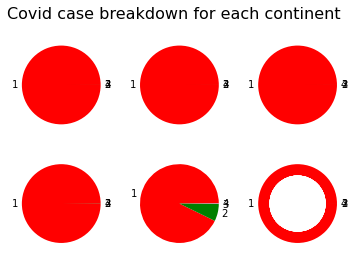

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=round(len(continents_df)/2))
labels = ['1','2','3','4']

# figure settings
fig.suptitle('Covid case breakdown for each continent', fontsize=16)


for i, continent in continents_df.iterrows():
    continentData = list(continent[5:9])
    my_circle = plt.Circle( (0,0), 0.7, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    if i < 3:
        ax[0][i].pie(continentData, labels=labels, colors=['red','green','blue','skyblue'])
    else:
        ax[1][i-3].pie(continentData, labels=labels, colors=['red','green','blue','skyblue'])

## Here we extract country data from the main dataframe, and dump it into a new dataframe.

In [77]:
countries_df = df.loc[7:len(df)]

# strip useless columns, clean data
countries_df = countries_df.drop(columns=['#','Tot\xa0Cases/1M pop','Deaths/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop']).reset_index(drop=True)

# sort the data by total cases, as we did with continents:
countries_df = countries_df.sort_values(by=['TotalCases'],ascending=False)
countries_df.head(10)


,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Population,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,USA,34348418,9047,615638,285,28574794,29023,5157986,4349,332849650,North America,27,0.9,15496
1,India,29632261,62226,379601,1470,28380634,107854,872026,8944,1392901572,Asia,45,1,626
2,Brazil,17533221,78360,490696,2292,15944646,90382,1097879,8318,213996756,South America,366,11,5130
3,France,5744589,3235,110530,76,5511242,12583,122817,1952,65411076,Europe,49,1,1878
4,Turkey,5342028,5955,48879,84,5211022,4186,82127,886,85201530,Asia,70,1.0,964
5,Russia,5236593,14185,127180,379,4818244,8597,291169,2300,145994086,Europe,97,3,1994
6,UK,4581006,7673,127917,10,4292182,2404,160907,188,68225401,Europe,112,0.1,2358
7,Italy,4247032,1255,127101,63,4014045,5016,105886,504,60377078,Europe,21,1,1754
8,Argentina,4145482,NaN,86029,NaN,3748794,NaN,310659,7969,45590077,South America,NaN,NaN,6814
9,Colombia,3777600,NaN,96366,NaN,3510709,NaN,170525,8155,51398316,South America,NaN,NaN,3318


# Let's now look at individual countries

In [ ]:
country_totals_df = countries_df[['Country,Other', 'TotalCases']]
country_totals_df = country_totals_df.head(10)
country_totals_df['TotalCases'] = country_totals_df['TotalCases']/1000000

country_totals_df.plot(kind='bar', x="Country,Other", y="TotalCases")
plt.ylabel("Millions")
plt.xticks(rotation=80)
